In [53]:
import os
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from collections import defaultdict

In [54]:
def construct_tree_from_xml(path):
    graph = defaultdict(list)
    
    xml_graph = nx.read_graphml(path)
    nodes = xml_graph.nodes()
    edges = xml_graph.edges()
    
    possible_tree_start = set(nodes)
    for edge in edges:
        possible_tree_start.remove(edge[1])
        
        if edge[1] in graph[edge[0]]:
            assert len(possible_tree_start) == 1, "Tree is not valid"
        graph[edge[0]].append(edge[1])
    
    possible_tree_start = list(possible_tree_start)
    assert len(possible_tree_start) == 1, "Tree is not valid"
    tree_start = possible_tree_start[0]
    return tree_start, graph



class Tree:
    def __init__(self, path):
        self._tree_start, self._tree = construct_tree_from_xml(path)
        self.x_coord = dict()
        self.y_coord = dict()
        
        
    def _in_order(self, vertex, depth, num):
        self.y_coord[vertex] = depth
        num_children = len(self._tree[vertex])
        
        for vn in self._tree[vertex][:(num_children + 1)//2]:
            num = self._in_order(vn, depth - 1, num)
        self.x_coord[vertex] = num
        num = num + 1
        for vn in self._tree[vertex][(num_children + 1)//2:]:
            num = self._in_order(vn, depth - 1, num)
            
        return num
        
        
    def in_order(self):        
        self._in_order(self._tree_start, 0, 0)
        min_depth = min(self.y_coord.values())
        self.y_coord = {key: value - min_depth for key, value in self.y_coord.items()}
        
    
    def _get_distance_between_contours(self, cl, cr, init_d = 2):
        max_depth = min([max(cl.keys()), max(cr.keys())]) + 1
        dist = cl[0][1] + init_d - cr[0][0]
        for depth in range(1, max_depth):
            dist = max([dist, cl[depth][1] + 1 - cr[depth][0]])
        return dist
            
            
    def _shift_subtree(self, vertex, dist):
        self.x_coord[vertex] += dist
        for child in self._tree[vertex]:
            self._shift_subtree(child, dist)
    
    
    def _merge_contours(self, contours):
        contour = dict()
        temp = []
        depth = 0
        while temp or depth == 0:
            temp = []
            for contour in contours:
                if depth in contour:
                    temp.extend(contour[depth])
            if temp:
                contour[depth] = [min(temp), max(temp)]
            depth += 1
        return contour
        
    
    def _compress(self, vertex): 
        contour = defaultdict(list)
        
        children = self._tree[vertex]
        contours = dict()
        for child in children:
            contours[child] = self._compress(child)
            
        if len(children) == 0: 
            contour[0] = [self.x_coord[vertex], self.x_coord[vertex]]
            return contour
        
        if len(children) == 1:
            self.x_coord[vertex] = self.x_coord[children[0]]
            contour[0] = [self.x_coord[vertex], self.x_coord[vertex]]
            for depth in contours[children[0]].keys():
                contour[depth + 1] = contours[children[0]][depth]
            return contour
        
        merged_contour = contours[children[0]]
        for i in range(1, len(children)):
            if len(children) > 2:
                dist = self._get_distance_between_contours(merged_contour, 
                                                           contours[children[i]], init_d = 1)
            else:
                dist = self._get_distance_between_contours(merged_contour, 
                                                           contours[children[i]])
            if dist < 0:
                self._shift_subtree(children[i], dist)
                contours[children[i]] = {key: [value[0] + dist, value[1] + dist] 
                                         for key, value in contours[children[i]].items()}
            
            merged_contour = self._merge_contours([merged_contour, contours[children[i]]])
        
        
        self.x_coord[vertex] = sum(self.x_coord[child] for child in children) // len(children)
        
        contour[0] = [self.x_coord[vertex], self.x_coord[vertex]]
        
        merged_contour = self._merge_contours(contours.values())
        for key, value in merged_contour.items():
            contour[key + 1] = value
        
        return contour
        
        
    
    def compress(self):
        self._compress(self._tree_start)
        
    def draw(self, compress=True):
        self.in_order()
        if compress:
            self.compress()
        
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_subplot(1, 1, 1)
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_major_locator(MultipleLocator(1))
        plt.grid()
        for node in self._tree.keys():
            for child in self._tree[node]:
                plt.plot([self.x_coord[node], self.x_coord[child]], 
                         [self.y_coord[node], self.y_coord[child]], 
                         color='red', marker='o', linestyle='solid')
        plt.show()

In [51]:
path = './examples/7.xml'
tree = Tree(path)

Example:  1b.xml
Without compression


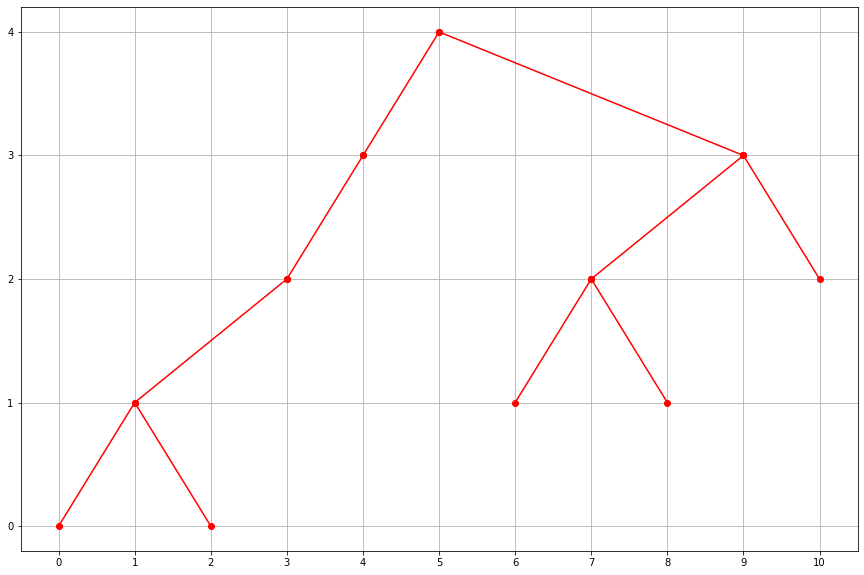

With compression


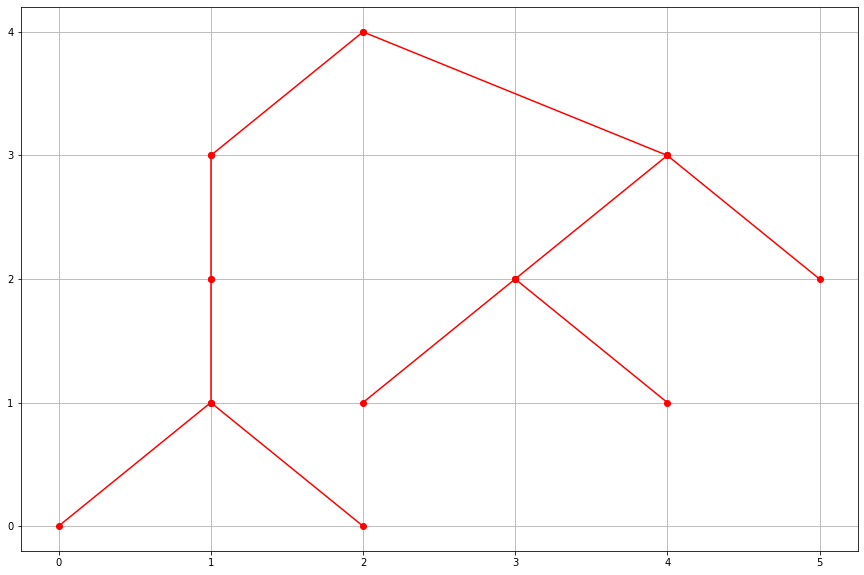

Example:  2b.xml
Without compression


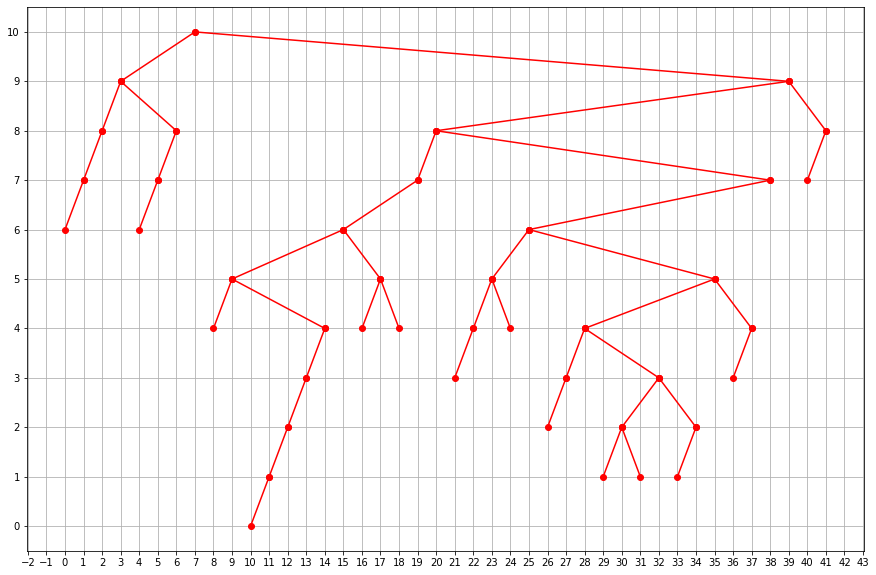

With compression


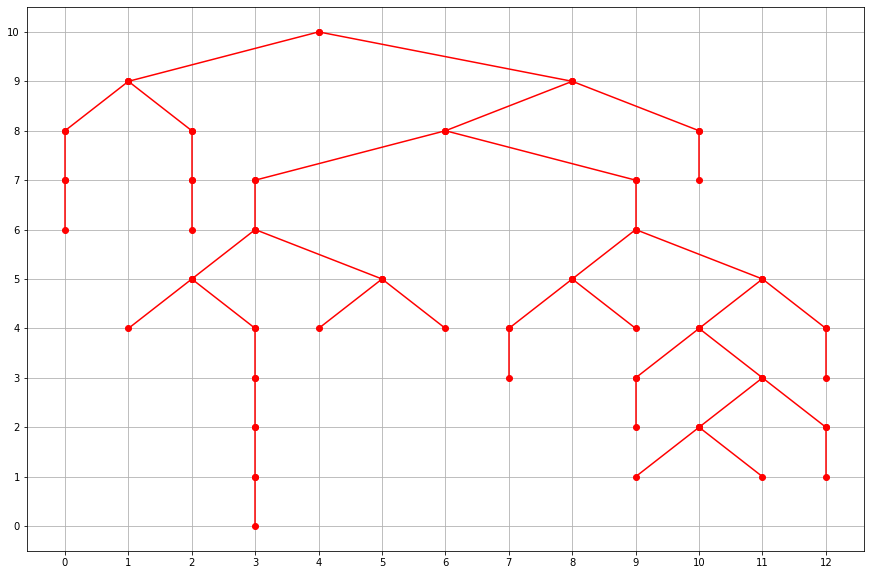

Example:  3b.xml
Without compression


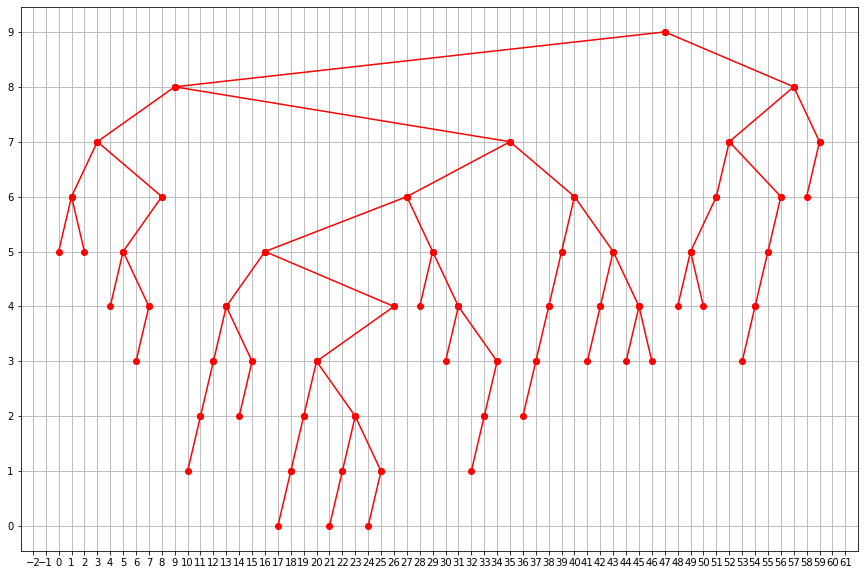

With compression


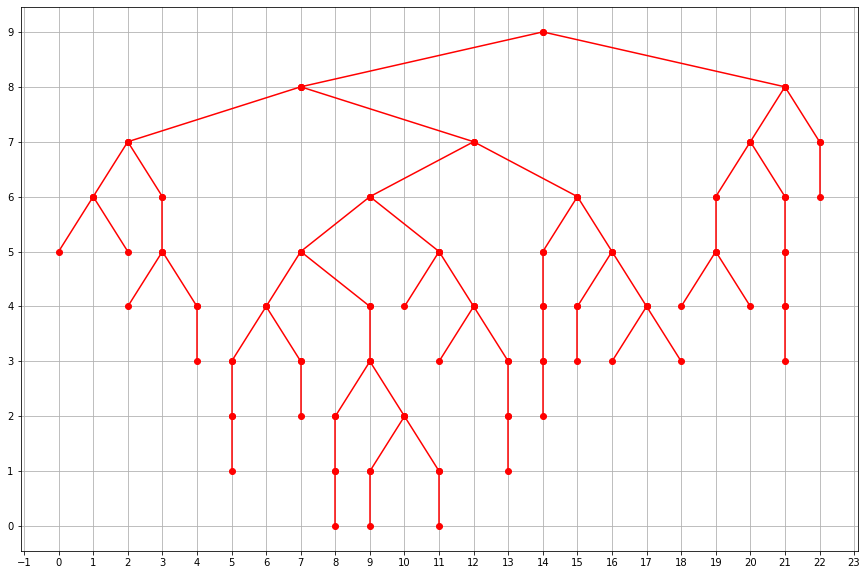

Example:  4b.xml
Without compression


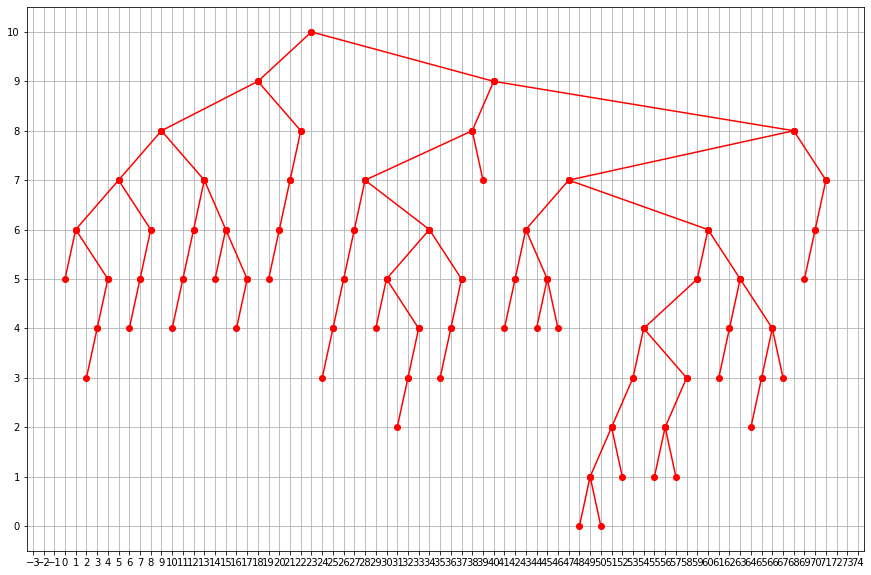

With compression


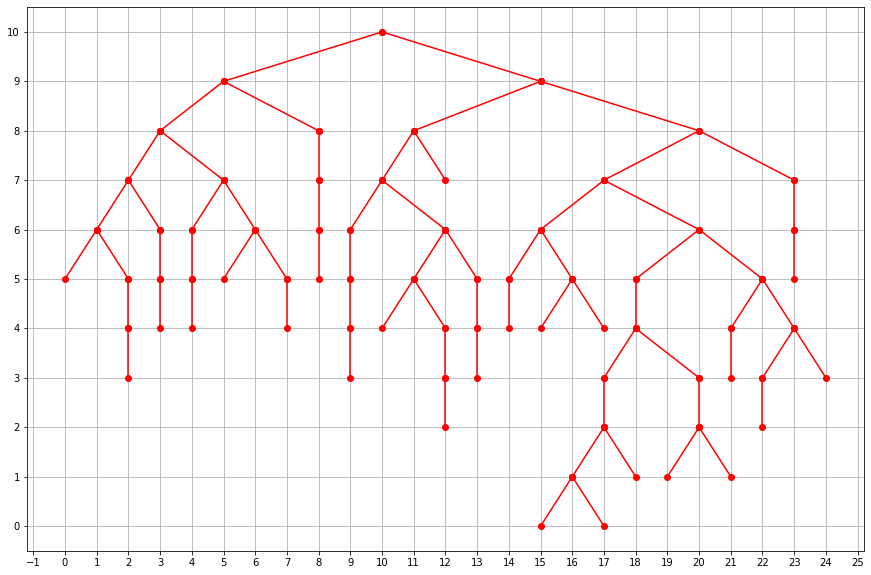

Example:  5b.xml
Without compression


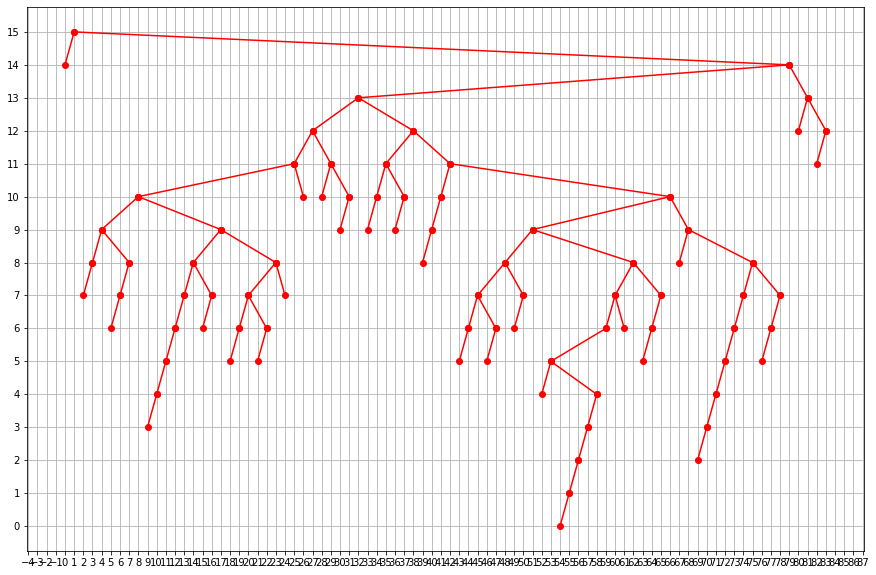

With compression


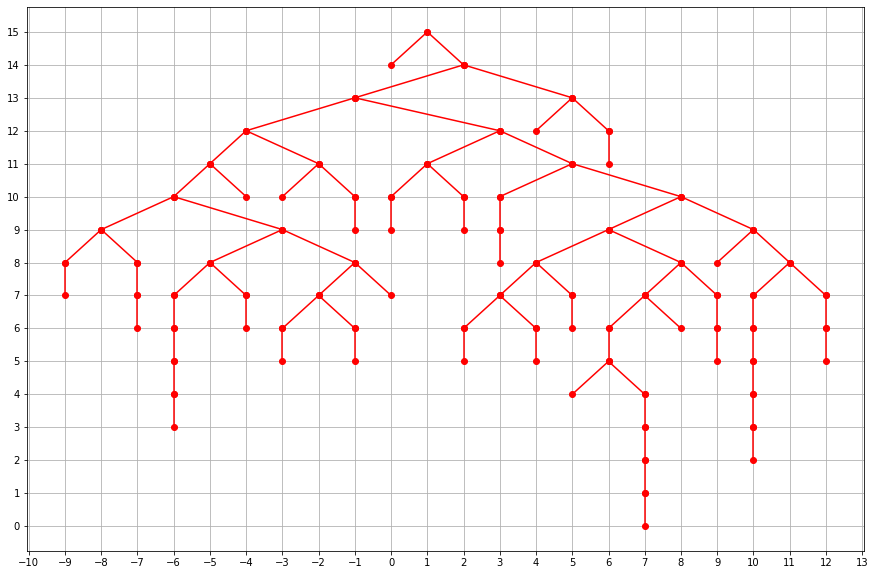

Example:  6.xml
Without compression


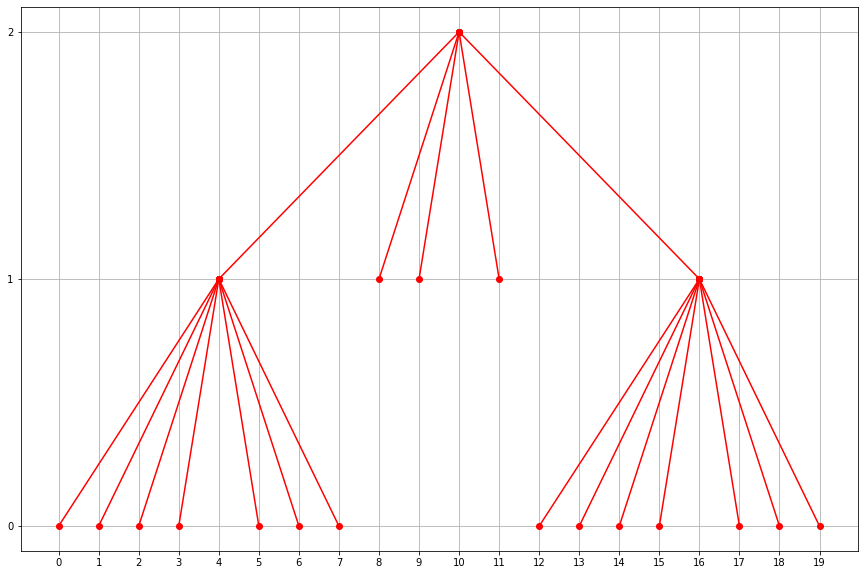

With compression


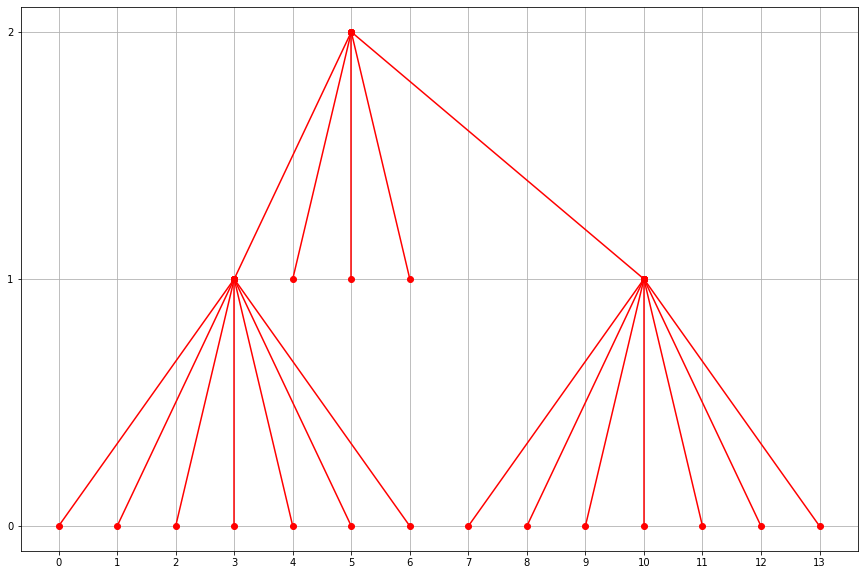

Example:  7.xml
Without compression


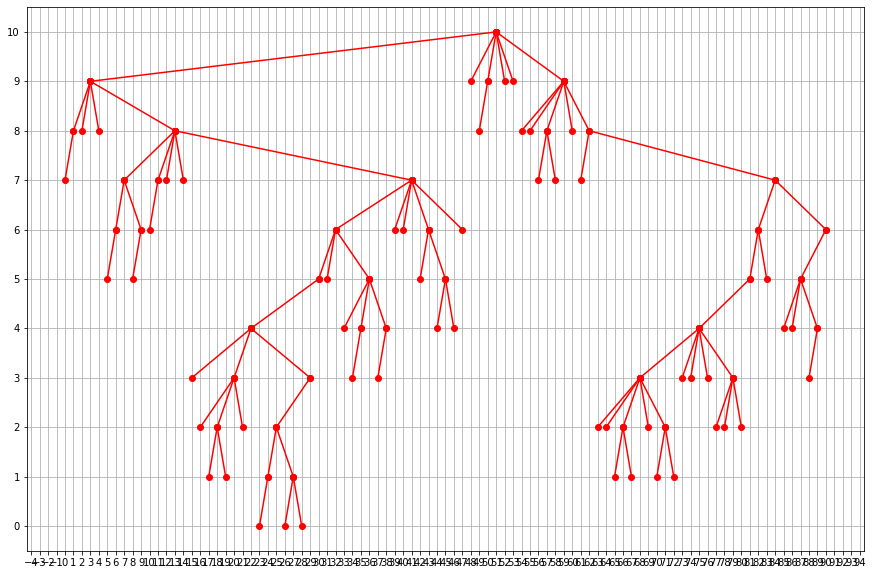

With compression


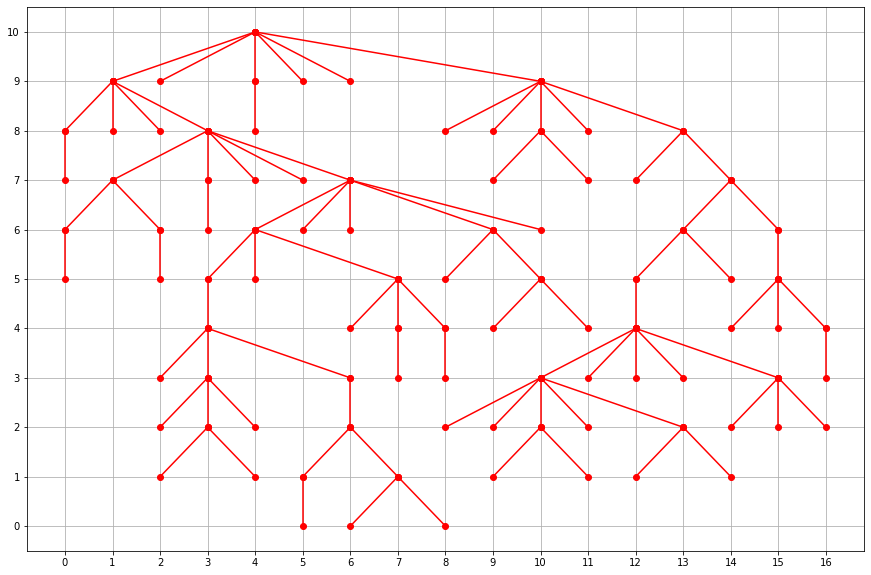

In [58]:
ex_folder = './examples/'
files = sorted(list(os.listdir(ex_folder)))
for filename in files:
    if '.xml' not in filename:
        continue
    path = ex_folder + filename
    print("Example: ", filename)
    tree = Tree(path)
    print("Without compression")
    tree.draw(compress=False)
    print("With compression")
    tree.draw()